In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Path to your log file (adjust as needed)
log_file = "../logs/exchange.log"

with open(log_file, "r") as f:
    log_lines = f.readlines()

print(f"Loaded {len(log_lines)} log lines.")


Loaded 13 log lines.


In [3]:
import re

# Updated regex patterns
order_pattern = re.compile(
    r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)\s+\[INFO\]\s+N:\s+Placed new order Order\(id=(\d+),\s+side=([BS]),\s+price=([\d\.]+),\s+qty=(\d+),\s+active=True\)\s+\(Fair=\s*([\d\.]+),\s*Mkt=\s*([\d\.]+)\)\s+using\s+(.+)$"
)

trade_pattern = re.compile(
    r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)\s+\[INFO\]\s+T:\s+Trade executed: .*?for\s+(\d+)\s+units\s+at\s+Rs\s+([\d\.]+)\.\s+LTP=([\d\.]+)$"
)

day_pattern = re.compile(
    r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)\s+\[INFO\]\s+===== DAY (\d+) START =====$"
)

In [4]:
# Data storage
order_data = []
trade_data = []
day_markers = []

# Read the log file
with open(log_file, "r") as f:
    for line in f:
        line = line.strip()

        # Match order lines
        o_match = order_pattern.match(line)
        if o_match:
            dt = datetime.strptime(o_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
            order_data.append({
                "timestamp": dt,
                "order_id": int(o_match.group(2)),
                "side": o_match.group(3),
                "order_price": float(o_match.group(4)),
                "qty": int(o_match.group(5)),
                "fair_value": float(o_match.group(6)),
                "market_price": float(o_match.group(7)),
                "profile": o_match.group(8)
            })

        # Match trade lines
        t_match = trade_pattern.match(line)
        if t_match:
            dt = datetime.strptime(t_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
            trade_data.append({
                "timestamp": dt,
                "trade_price": float(t_match.group(3)),
                "LTP": float(t_match.group(4))
            })

        # Match day markers
        d_match = day_pattern.match(line)
        if d_match:
            dt = datetime.strptime(d_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
            day_markers.append({"timestamp": dt, "day": int(d_match.group(2))})

# Create DataFrames
df_orders = pd.DataFrame(order_data)
df_trades = pd.DataFrame(trade_data)
df_days = pd.DataFrame(day_markers)

# Check if timestamp column exists before sorting
if "timestamp" in df_orders.columns:
    df_orders.sort_values(by=["timestamp"], inplace=True)
else:
    print("Warning: 'timestamp' column not found in df_orders")

if "timestamp" in df_trades.columns:
    df_trades.sort_values(by=["timestamp"], inplace=True)

if "timestamp" in df_days.columns:
    df_days.sort_values(by=["timestamp"], inplace=True)

# Display the structure
print("Orders sample:")
print(df_orders.head())
print("\nTrades sample:")
print(df_trades.head())
print("\nDay markers:")
print(df_days.head())

Orders sample:
                   timestamp  order_id side  order_price  qty  fair_value  \
0 2025-04-07 17:33:45.931910         1    S       699.20   14      699.20   
1 2025-04-07 17:33:45.933929         4    S       699.25    1      699.25   
2 2025-04-07 17:33:45.934222         5    B       699.20    2      699.20   
3 2025-04-07 17:33:45.935565         7    B       699.85   23      699.85   
4 2025-04-07 17:33:45.935838         8    B       699.85    4      699.85   

   market_price                profile  
0        700.00        Momentum Trader  
1        699.20      Contrarian Seller  
2        699.20  Trend Reversal Trader  
3        699.25           Market Maker  
4        699.20      Aggressive Seller  

Trades sample:
                   timestamp  trade_price     LTP
0 2025-04-07 17:33:45.932303       699.05  700.00
1 2025-04-07 17:33:45.933164       699.05  699.05
2 2025-04-07 17:33:45.934471       699.30  699.05
3 2025-04-07 17:33:46.069761       700.80  699.30
4 2025-04-

In [5]:
# Define a sampling frequency. Adjust as needed.
SAMPLING_FREQ = "60s"  # 10 seconds

# Resample orders and trades based on the timestamp.
# We take the last entry in each interval.
if not df_orders.empty:
    df_orders_sample = df_orders.set_index("timestamp").resample(SAMPLING_FREQ).last().dropna().reset_index()
else:
    df_orders_sample = df_orders.copy()

if not df_trades.empty:
    df_trades_sample = df_trades.set_index("timestamp").resample(SAMPLING_FREQ).last().dropna().reset_index()
else:
    df_trades_sample = df_trades.copy()

print("Sampled Orders:")
print(df_orders_sample.head())
print("\nSampled Trades:")
print(df_trades_sample.head())


Sampled Orders:
            timestamp  order_id side  order_price  qty  fair_value  \
0 2025-04-07 17:33:00      1165    S       695.40   14      695.40   
1 2025-04-07 17:34:00      6120    S       676.95    2      676.95   
2 2025-04-07 17:35:00     11304    S       673.60    6      673.60   
3 2025-04-07 17:36:00     17390    S       674.90    5      674.90   
4 2025-04-07 17:37:00     23652    S       689.90   18      689.90   

   market_price            profile  
0        691.60    Momentum Trader  
1        674.25    Momentum Trader  
2        673.55  Aggressive Seller  
3        676.90  Aggressive Seller  
4        688.50    Momentum Trader  

Sampled Trades:
            timestamp  trade_price     LTP
0 2025-04-07 17:33:00       694.50  694.25
1 2025-04-07 17:34:00       674.25  674.40
2 2025-04-07 17:35:00       674.10  674.05
3 2025-04-07 17:36:00       674.95  675.30
4 2025-04-07 17:37:00       688.60  688.50


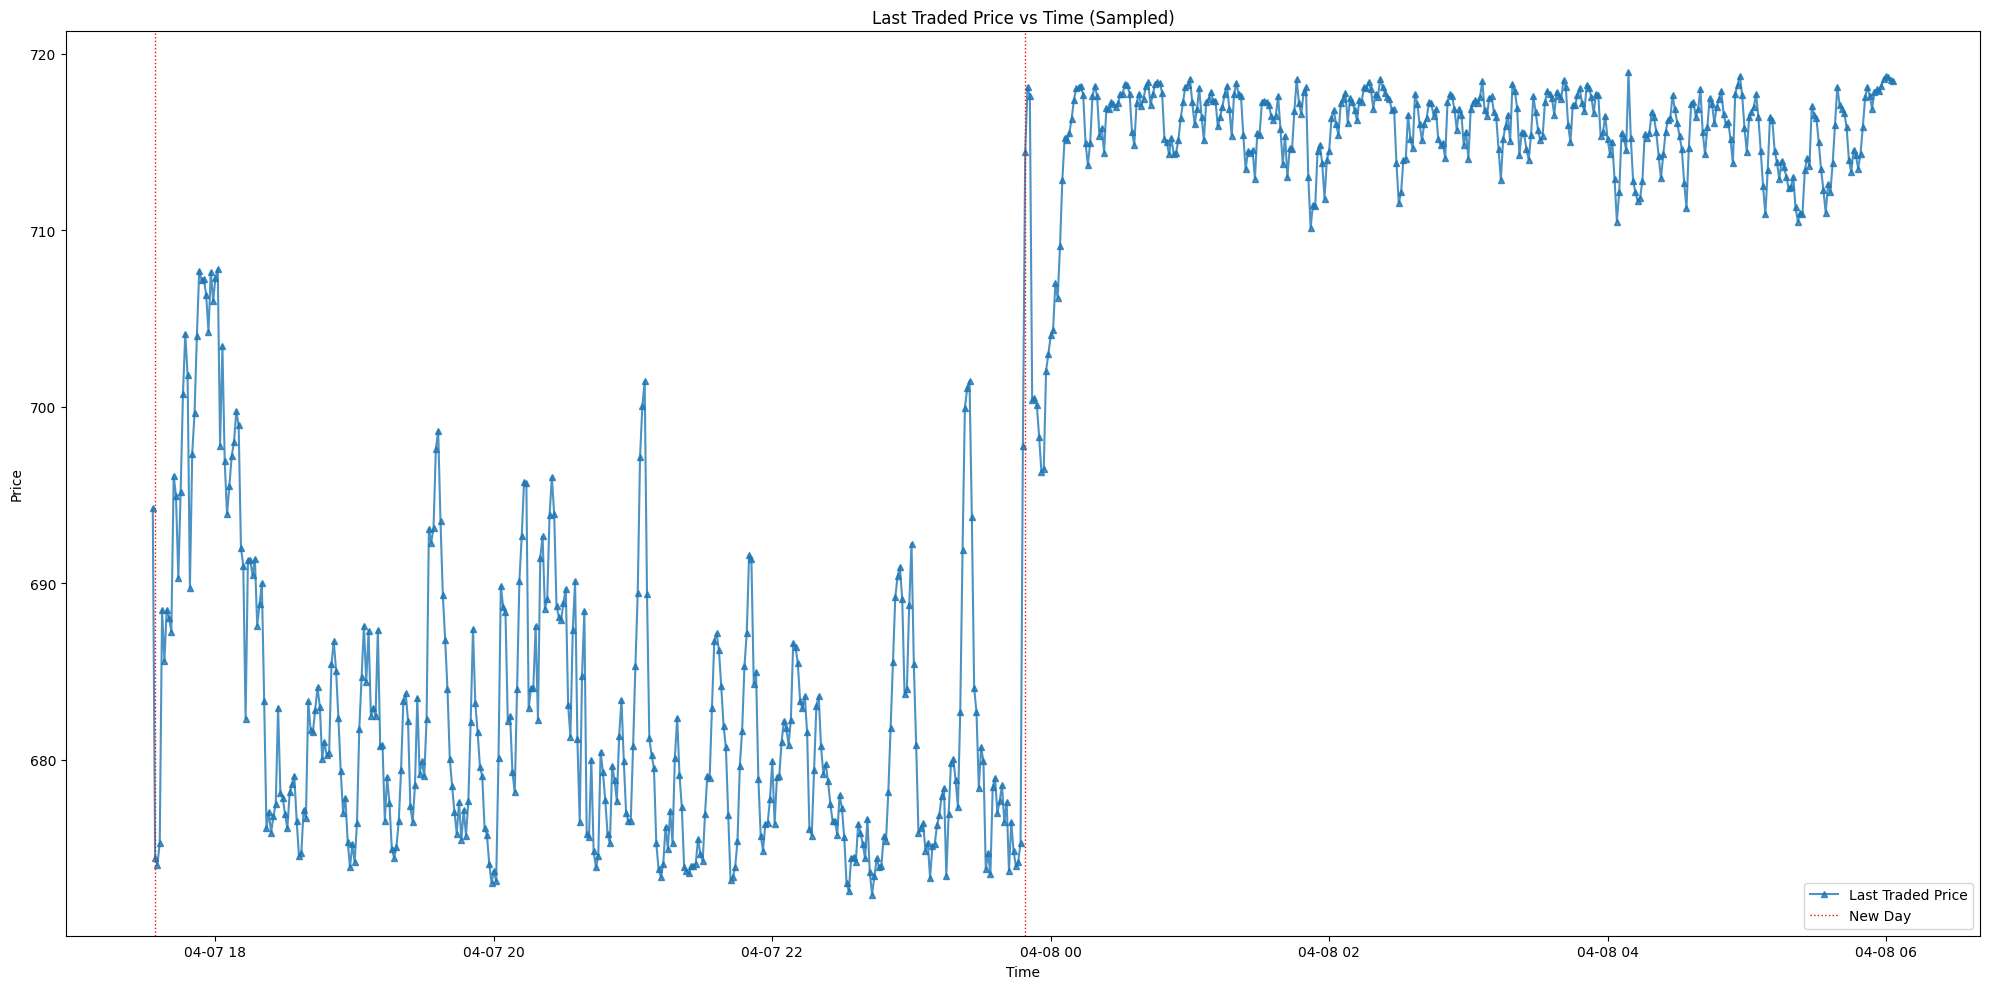

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
if not df_trades_sample.empty:
    plt.plot(df_trades_sample["timestamp"], df_trades_sample["LTP"], marker="^", markersize=4, linestyle="-", alpha=0.8, label="Last Traded Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Last Traded Price vs Time (Sampled)")

# Add vertical lines at day marker timestamps.
for idx, row in df_days.iterrows():
    plt.axvline(x=row["timestamp"], color="red", linestyle="dotted", linewidth=1, label="New Day" if idx == 0 else "")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"
# Create a Plotly figure
fig = go.Figure()

# Check if the trades DataFrame is not empty and add the trace for Last Traded Price
if not df_trades_sample.empty:
    fig.add_trace(
        go.Scatter(
            x=df_trades_sample["timestamp"],
            y=df_trades_sample["LTP"],
            mode="lines+markers",
            marker=dict(symbol="triangle-up", size=6),  # Adjust marker size as needed
            line=dict(width=1),
            name="Last Traded Price"
        )
    )

# Add vertical lines for each new day marker from df_days
for idx, row in df_days.iterrows():
    fig.add_shape(
        type="line",
        x0=row["timestamp"],
        y0=df_trades_sample["LTP"].min(),  # You can set custom y-axis limits if needed
        x1=row["timestamp"],
        y1=df_trades_sample["LTP"].max(),
        line=dict(color="red", dash="dot", width=1),
        # Optionally, add a label only once using annotation if required.
    )

    # Add annotation for the day (label above line)
    fig.add_annotation(
        x=row["timestamp"],
        y=df_trades_sample["LTP"].max(),  # Position at top of y-axis
        text=f"Day {row['day']}",
        showarrow=False,
        yshift=10,
        font=dict(size=10, color="red"),
        align="center"
    )

# Update layout with titles and axis labels
fig.update_layout(
    title="Last Traded Price vs Time (Sampled)",
    xaxis_title="Time",
    yaxis_title="Price",
    template="plotly_white",  # Use a clean white template
    width=1800,
    height=900,

    # Ensure y-axis is not fixed
    yaxis=dict(
        fixedrange=False,  # This allows zooming in Y-axis
        autorange=True
    ),

    # Ensure x-axis is also interactive
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date",
        fixedrange=False  # Allow panning/zooming on X-axis
    ),

    dragmode='zoom',  # Allows drag-to-zoom interaction
)

# Display the interactive figure
fig.show()


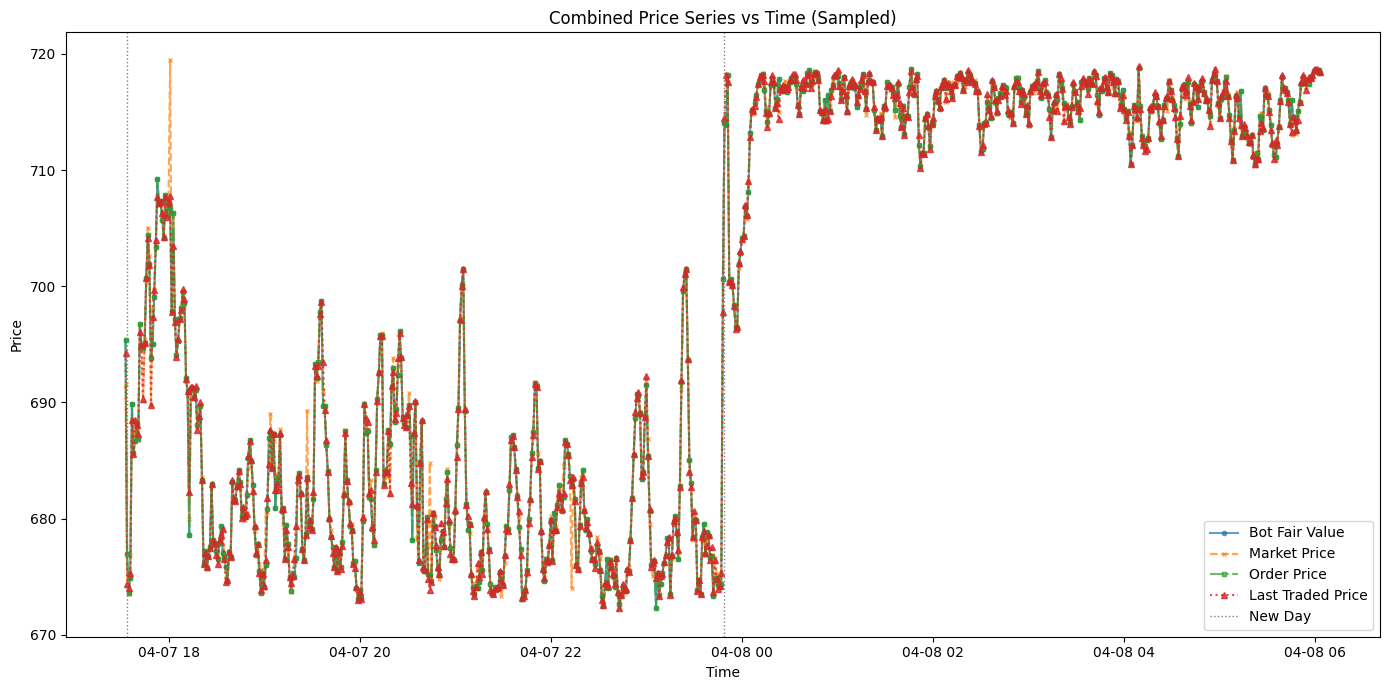

In [8]:
plt.figure(figsize=(14,7))
if not df_orders_sample.empty:
    plt.plot(df_orders_sample["timestamp"], df_orders_sample["fair_value"], marker="o", markersize=3, linestyle="-", alpha=0.7, label="Bot Fair Value")
    plt.plot(df_orders_sample["timestamp"], df_orders_sample["market_price"], marker="x", markersize=3, linestyle="--", alpha=0.7, label="Market Price")
    plt.plot(df_orders_sample["timestamp"], df_orders_sample["order_price"], marker="s", markersize=3, linestyle="-.", alpha=0.7, label="Order Price")
if not df_trades_sample.empty:
    plt.plot(df_trades_sample["timestamp"], df_trades_sample["LTP"], marker="^", markersize=4, linestyle=":", alpha=0.8, label="Last Traded Price")
    
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Combined Price Series vs Time (Sampled)")
    
# Add vertical dividers at day marker timestamps.
for idx, row in df_days.iterrows():
    plt.axvline(x=row["timestamp"], color="grey", linestyle="dotted", linewidth=1, label="New Day" if idx==0 else "")
    
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf  # For OHLC plotting

def resample_trades(df_trades, timeframe='1S'):
    """
    Resamples the trade data to create OHLC bars while keeping the original timestamp column.

    Parameters:
        df_trades (pd.DataFrame): DataFrame containing trade data with timestamps.
        timeframe (str): Pandas-style timeframe string (e.g., '1S' for 1-second bars, '5S' for 5-second bars, '1T' for 1-minute bars).

    Returns:
        pd.DataFrame: Resampled OHLC DataFrame (timestamp intact).
    """

    if df_trades.empty:
        print("Error: The trade DataFrame is empty.")
        return None

    # Make a copy to preserve original data
    df_resampled = df_trades.copy()

    # Ensure timestamp is a datetime index
    df_resampled.set_index("timestamp", inplace=True)

    # Resample using OHLC aggregation
    ohlc_df = df_resampled["trade_price"].resample(timeframe).ohlc()

    # Drop NaN values (occurs when no trades happened in a period)
    ohlc_df.dropna(inplace=True)

    # Reset index to keep timestamp as a column
    ohlc_df.reset_index(inplace=True)

    return ohlc_df

import plotly.graph_objects as go

def plot_ohlc_chart(ohlc_df, timeframe):
    """
    Plots the OHLC chart using Plotly for interactive zooming, panning, etc.

    Parameters:
        ohlc_df (pd.DataFrame): Resampled OHLC data with timestamp column.
        timeframe (str): The timeframe for display in the title.
    """

    if ohlc_df is None or ohlc_df.empty:
        print("Error: No data available for plotting.")
        return

    fig = go.Figure(data=[go.Candlestick(
        x=ohlc_df['timestamp'],
        open=ohlc_df['open'],
        high=ohlc_df['high'],
        low=ohlc_df['low'],
        close=ohlc_df['close'],
        increasing_line_color='green',
        decreasing_line_color='red'
    )])

    fig.update_layout(
        title=f"OHLC Chart ({timeframe})",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=True,
        height=900,
        width=1800,
        template='plotly_white',

        # Ensure y-axis is not fixed
        yaxis=dict(
            fixedrange=False,  # This allows zooming in Y-axis
            autorange=True
        ),

        # Ensure x-axis is also interactive
        xaxis=dict(
            rangeslider=dict(visible=True),
            type="date",
            fixedrange=False  # Allow panning/zooming on X-axis
        ),

        dragmode='zoom',  # Allows drag-to-zoom interaction
    )

    fig.show()


# Example Usage:
# Adjust the timeframe as needed (e.g., '5S', '10S', '1T' for 1-minute)
timeframe = "1s"  # Change this to adjust the granularity
# Ensure df_trades has a timestamp column before running
if "timestamp" in df_trades.columns:
    ohlc_data = resample_trades(df_trades, timeframe)
    print(ohlc_data.head())  # Print a sample
    plot_ohlc_chart(ohlc_data, timeframe)
else:
    print("Error: 'timestamp' column not found in df_trades.")


            timestamp    open    high     low   close
0 2025-04-07 17:33:45  699.05  699.30  699.05  699.30
1 2025-04-07 17:33:46  700.80  700.80  698.20  699.90
2 2025-04-07 17:33:47  698.20  700.20  697.50  699.15
3 2025-04-07 17:33:48  699.05  699.90  696.00  696.20
4 2025-04-07 17:33:49  696.10  700.15  695.45  698.75


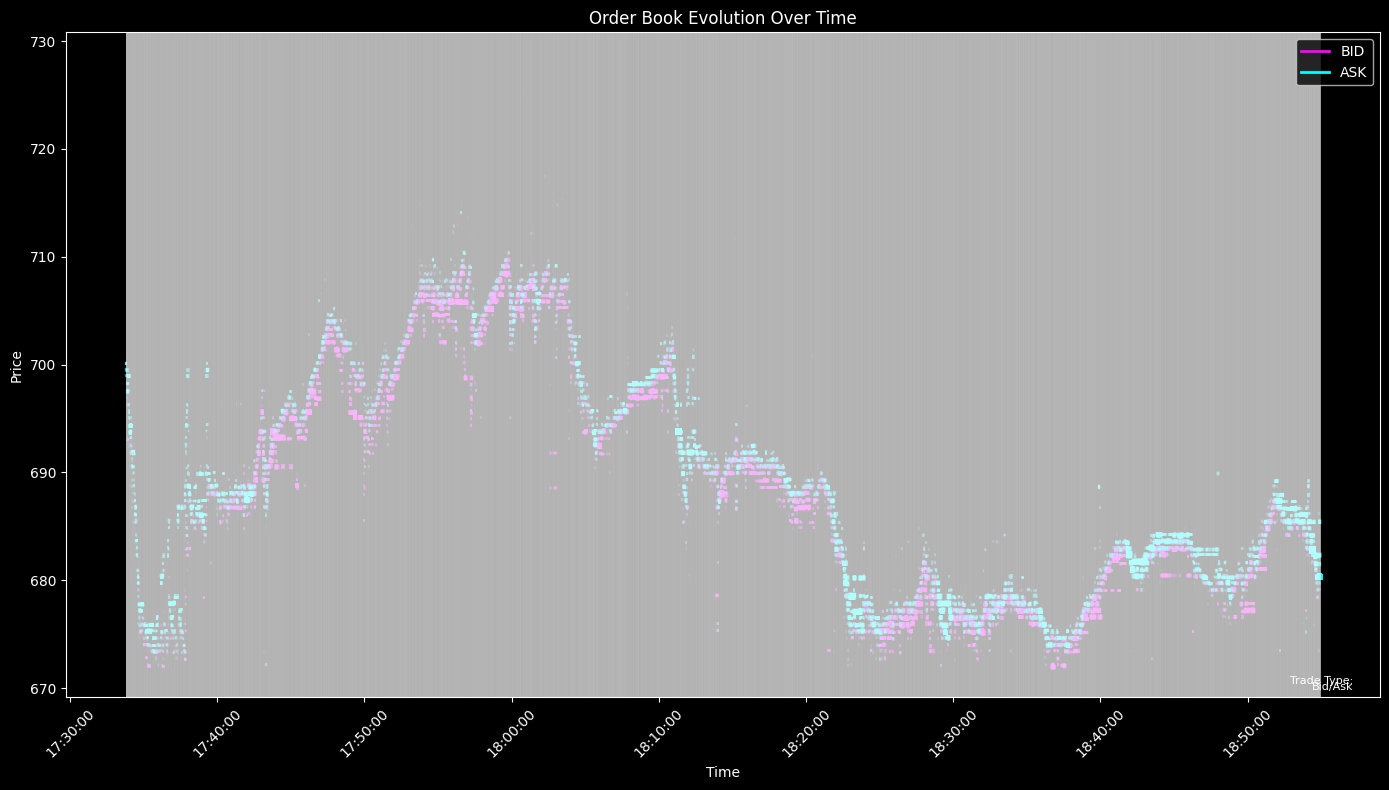

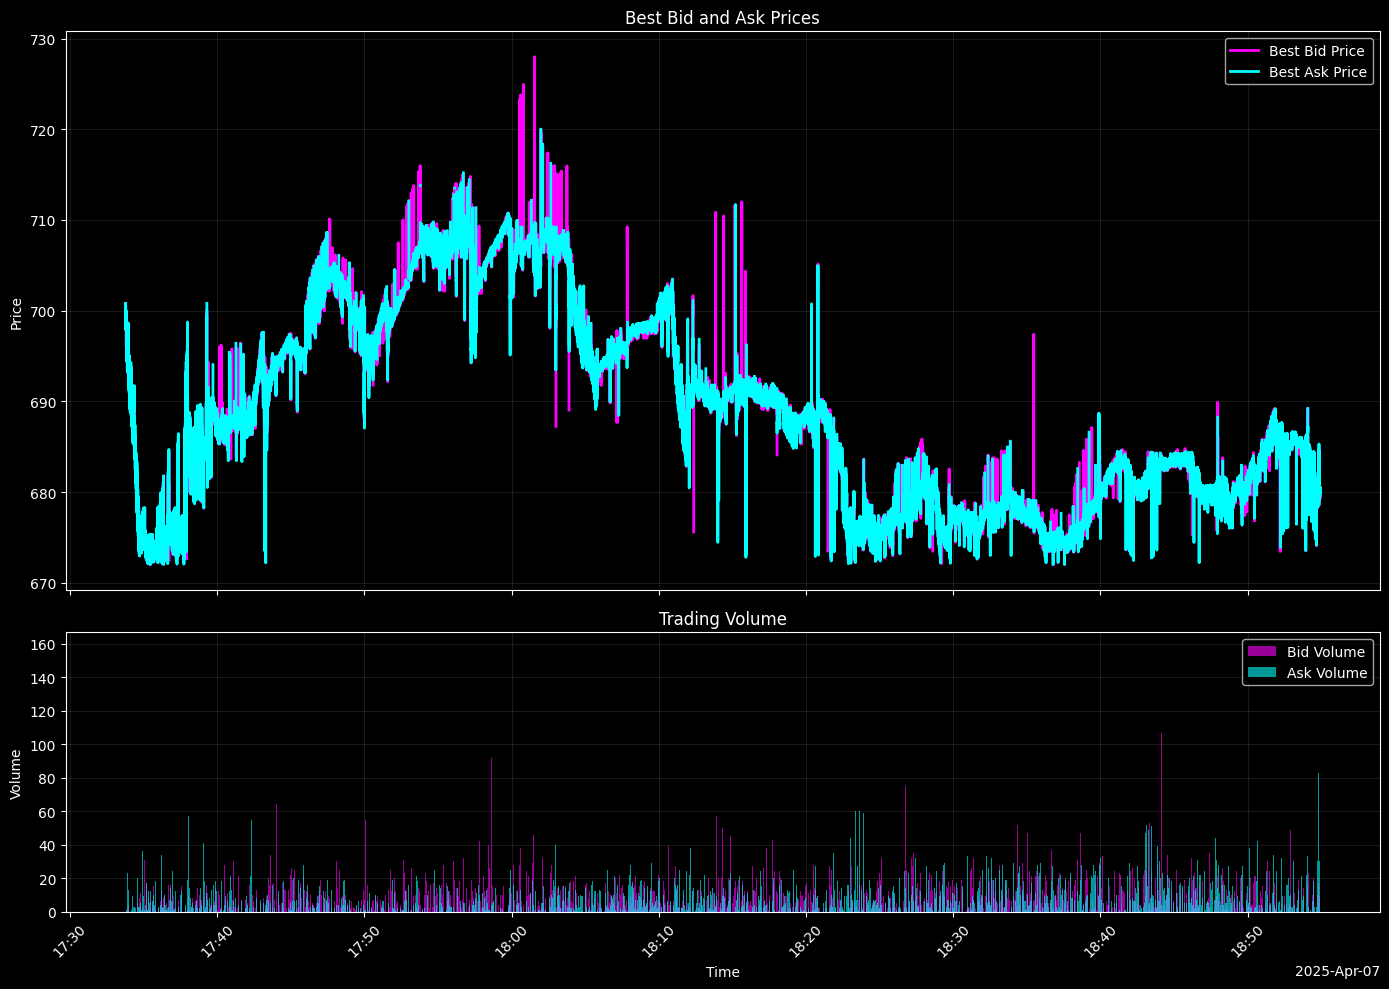

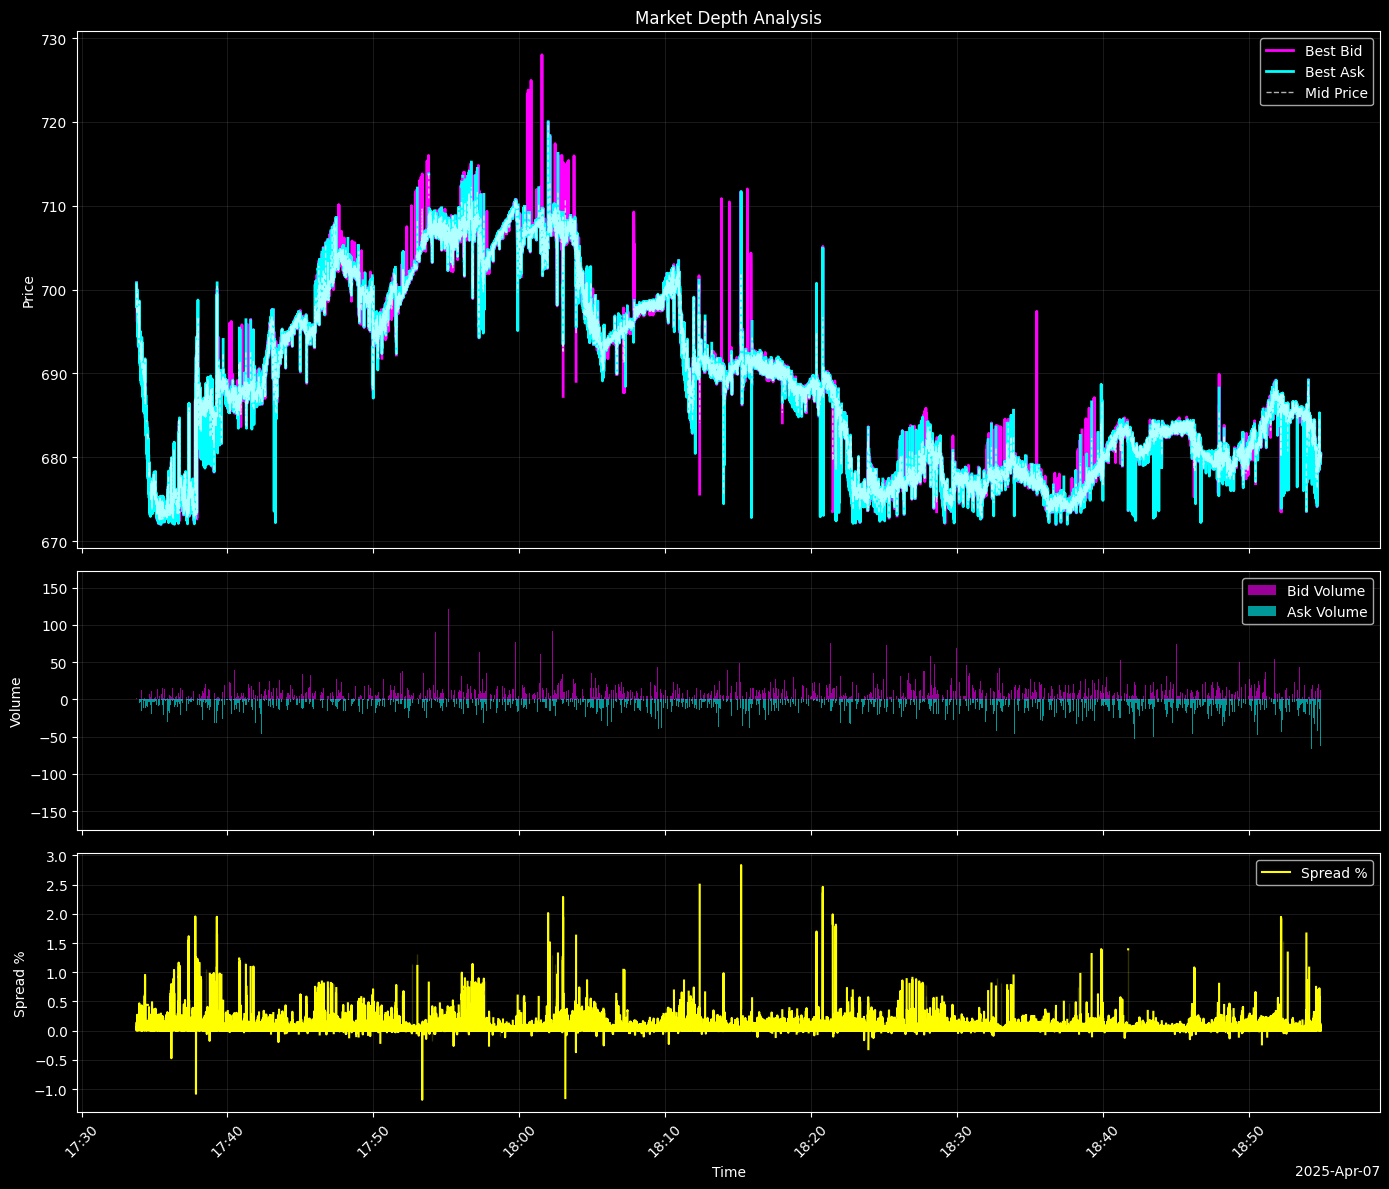

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import matplotlib.colors as mcolors
import re

# Function to parse the new log format
def parse_log(log_text):
    data = []
    
    # Regular expression to match timestamp, type, price, and volume
    pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+) \[INFO\] SNAPSHOT,([^,]+),(BID|ASK),(\d+\.\d+),(\d+)'
    
    for line in log_text.strip().split('\n'):
        match = re.search(pattern, line)
        if match:
            timestamp_str = match.group(1)
            snapshot_time = match.group(2)
            order_type = match.group(3)
            price = float(match.group(4))
            volume = int(match.group(5))
            
            data.append([timestamp_str, snapshot_time, order_type, price, volume])
    
    return data

# Read the log file
with open('../logs/order_book.log', 'r') as f:
    log_data = f.read()

# Parse the log
parsed_data = parse_log(log_data)

# Create DataFrame
df = pd.DataFrame(parsed_data, 
                  columns=['log_timestamp', 'snapshot_timestamp', 'order_type', 'price', 'volume'])

# Convert timestamps to datetime objects
df['log_timestamp'] = pd.to_datetime(df['log_timestamp'])
df['snapshot_timestamp'] = pd.to_datetime(df['snapshot_timestamp'])

# Extract best bid and ask for each snapshot
def extract_best_prices(df):
    snapshots = df['snapshot_timestamp'].unique()
    best_prices = []
    
    for snapshot in snapshots:
        snapshot_data = df[df['snapshot_timestamp'] == snapshot]
        
        # Get best bid (highest price)
        bids = snapshot_data[snapshot_data['order_type'] == 'BID']
        if not bids.empty:
            best_bid = bids.loc[bids['price'].idxmax()]
            best_bid_price = best_bid['price']
            best_bid_volume = best_bid['volume']
        else:
            best_bid_price = np.nan
            best_bid_volume = 0
        
        # Get best ask (lowest price)
        asks = snapshot_data[snapshot_data['order_type'] == 'ASK']
        if not asks.empty:
            best_ask = asks.loc[asks['price'].idxmin()]
            best_ask_price = best_ask['price']
            best_ask_volume = best_ask['volume']
        else:
            best_ask_price = np.nan
            best_ask_volume = 0
        
        best_prices.append({
            'timestamp': snapshot,
            'best_bid_price': best_bid_price,
            'best_bid_volume': best_bid_volume,
            'best_ask_price': best_ask_price,
            'best_ask_volume': best_ask_volume,
            'spread': best_ask_price - best_bid_price if not (np.isnan(best_ask_price) or np.isnan(best_bid_price)) else np.nan
        })
    
    return pd.DataFrame(best_prices)

# Extract best prices
best_prices_df = extract_best_prices(df)

def plot_best_prices(best_prices_df):
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot best bid and ask prices on the top subplot
    ax1.plot(best_prices_df['timestamp'], best_prices_df['best_bid_price'], 
             color='magenta', linestyle='-', linewidth=2, label='Best Bid Price')
    ax1.plot(best_prices_df['timestamp'], best_prices_df['best_ask_price'], 
             color='cyan', linestyle='-', linewidth=2, label='Best Ask Price')
    
    # Fill the spread area
    ax1.fill_between(best_prices_df['timestamp'], 
                     best_prices_df['best_bid_price'], 
                     best_prices_df['best_ask_price'], 
                     color='white', alpha=0.1)
    
    # Plot volumes as separate subplot with bars
    # Calculate width based on time differences
    timestamps = best_prices_df['timestamp']
    if len(timestamps) > 1:
        avg_delta = (timestamps.iloc[-1] - timestamps.iloc[0]) / (len(timestamps) - 1)
        bar_width = avg_delta * 0.8
    else:
        bar_width = np.timedelta64(1, 's')  # Default to 1 second if only one timestamp
    
    # Use different colors for bid and ask volumes
    ax2.bar(best_prices_df['timestamp'], best_prices_df['best_bid_volume'], 
            width=bar_width, color='magenta', alpha=0.6, label='Bid Volume')
    ax2.bar(best_prices_df['timestamp'], best_prices_df['best_ask_volume'], 
            width=bar_width, color='cyan', alpha=0.6, label='Ask Volume')
    
    # Format x-axis with proper time intervals
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
    # Set labels
    ax1.set_ylabel('Price')
    ax1.set_title('Best Bid and Ask Prices')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.1)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volume')
    ax2.set_title('Trading Volume')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.1)
    
    plt.tight_layout()
    return fig

# Create a detailed heatmap visualization (from the previous code)
def plot_detailed_heatmap(df):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Get unique timestamps
    timestamps = sorted(df['snapshot_timestamp'].unique())
    
    # Create a structured representation of the data
    bid_data = []
    ask_data = []
    
    # Define color normalization
    max_volume = df['volume'].max()
    norm = mcolors.Normalize(0, max_volume)
    
    # Process each timestamp
    for ts in timestamps:
        ts_data = df[df['snapshot_timestamp'] == ts]
        
        # Get bids and asks
        bids = ts_data[ts_data['order_type'] == 'BID']
        asks = ts_data[ts_data['order_type'] == 'ASK']
        
        # Store bid data
        for _, bid in bids.iterrows():
            bid_data.append((ts, bid['price'], bid['volume']))
        
        # Store ask data
        for _, ask in asks.iterrows():
            ask_data.append((ts, ask['price'], ask['volume']))
    
    # Plot bids
    for ts, price, volume in bid_data:
        alpha = min(0.8, volume / max_volume + 0.1)
        linewidth = 1 + 5 * (volume / max_volume)
        ax.plot([ts, ts], [price - 0.01, price + 0.01], 
                color='magenta', alpha=alpha, linewidth=linewidth)
    
    # Plot asks
    for ts, price, volume in ask_data:
        alpha = min(0.8, volume / max_volume + 0.1)
        linewidth = 1 + 5 * (volume / max_volume)
        ax.plot([ts, ts], [price - 0.01, price + 0.01], 
                color='cyan', alpha=alpha, linewidth=linewidth)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=45)
    
    # Add time markers at the bottom
    for ts in timestamps:
        ax.axvline(x=ts, color='white', alpha=0.05, linewidth=0.5)
    
    # Set labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.set_title('Order Book Evolution Over Time')
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='magenta', lw=2, label='BID'),
        Line2D([0], [0], color='cyan', lw=2, label='ASK')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Add trade type indicator
    ax.text(0.98, 0.02, 'Trade Type:', transform=ax.transAxes, 
            color='white', fontsize=8, ha='right')
    ax.text(0.98, 0.01, 'Bid/Ask', transform=ax.transAxes, 
            color='white', fontsize=8, ha='right')
    
    plt.tight_layout()
    return fig

# Create a combined plot with price/volume and mid-price
def plot_combined_market_view(best_prices_df):
    plt.style.use('dark_background')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=True)
    
    # Calculate mid-price and spread percentage
    best_prices_df['mid_price'] = (best_prices_df['best_bid_price'] + best_prices_df['best_ask_price']) / 2
    best_prices_df['spread_pct'] = (best_prices_df['spread'] / best_prices_df['mid_price']) * 100
    
    # Plot 1: Best bid and ask prices
    ax1.plot(best_prices_df['timestamp'], best_prices_df['best_bid_price'], 
             color='magenta', linestyle='-', linewidth=2, label='Best Bid')
    ax1.plot(best_prices_df['timestamp'], best_prices_df['best_ask_price'], 
             color='cyan', linestyle='-', linewidth=2, label='Best Ask')
    ax1.plot(best_prices_df['timestamp'], best_prices_df['mid_price'], 
             color='white', linestyle='--', linewidth=1, alpha=0.7, label='Mid Price')
    
    # Fill the spread area
    ax1.fill_between(best_prices_df['timestamp'], 
                    best_prices_df['best_bid_price'], 
                    best_prices_df['best_ask_price'], 
                    color='white', alpha=0.1)
    
    # Calculate width based on time differences for bars
    timestamps = best_prices_df['timestamp']
    if len(timestamps) > 1:
        avg_delta = (timestamps.iloc[-1] - timestamps.iloc[0]) / (len(timestamps) - 1)
        bar_width = avg_delta * 0.8
    else:
        bar_width = np.timedelta64(1, 's')  # Default to 1 second if only one timestamp
    
    # Plot 2: Volume for best bid and ask as bars
    ax2.bar(best_prices_df['timestamp'], best_prices_df['best_bid_volume'], 
            width=bar_width, color='magenta', alpha=0.6, label='Bid Volume')
    ax2.bar(best_prices_df['timestamp'], -best_prices_df['best_ask_volume'], 
            width=bar_width, color='cyan', alpha=0.6, label='Ask Volume')
    
    # Plot 3: Spread in percentage
    ax3.plot(best_prices_df['timestamp'], best_prices_df['spread_pct'], 
             color='yellow', linewidth=1.5, label='Spread %')
    ax3.fill_between(best_prices_df['timestamp'], 0, best_prices_df['spread_pct'], 
                    color='yellow', alpha=0.2)
    
    # Format x-axis with proper time intervals
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax3.xaxis.set_major_locator(locator)
    ax3.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
    # Set labels and titles
    ax1.set_title('Market Depth Analysis')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.1)
    
    ax2.set_ylabel('Volume')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.1)
    
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Spread %')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.1)
    
    plt.tight_layout()
    return fig

# Create the plots
heatmap_fig = plot_detailed_heatmap(df)
best_prices_fig = plot_best_prices(best_prices_df)
combined_fig = plot_combined_market_view(best_prices_df)

# Display the plots
plt.show()

